In [3]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit
import itertools
import nafflib as NAFFlib



/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/miniforge/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [13]:

#collider = xt.Multiline.from_json('/afs/cern.ch/work/a/aradosla/private/example_DA_study/studies/scans/example_tunescan/base_collider/collider.json')
#collider = xt.Multiline.from_json('/afs/cern.ch/work/a/aradosla/private/example_DA_study_mine/master_study/scans/example_tunescan/base_collider/collider/collider.json')
collider = xt.Multiline.from_json('/afs/cern.ch/work/a/aradosla/private/example_DA_study_fma/studies/scans/example_tunescan_gpu/base_collider/collider.json')




Loading line from dict: 100%|██████████| 42430/42430 [00:05<00:00, 8360.36it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 42504/42504 [00:05<00:00, 8249.34it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 42430/42430 [00:05<00:00, 7967.10it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 42504/42504 [00:05<00:00, 7175.17it/s]


Done loading line from dict.           


In [16]:
sampling_frequency = 11245.5 # Sampling frequency in Hz
num_turns = 100
total_time = num_turns/sampling_frequency  # Total time in seconds
time = np.arange(0, total_time, 1 / sampling_frequency)

A = 1.  # Amplitude
f = 1000.  # Frequency
phi = 0.  # Phase
samples = A * np.sin(2 * np.pi * f * time + phi)

# Initialize the exciter
exciter = xt.Exciter(
    samples=samples,
    sampling_frequency=sampling_frequency,
    duration=num_turns / sampling_frequency,
    frev=sampling_frequency,
    knl=[0.000012]
)

# Insert the exciter into the specified line and index
collider['lhcb1'].insert_element(
    element=exciter,
    name='RF_KO_EXCITER',
    index= 'mq.7r3.b1..1_exit'
)
    
collider['lhcb1'].keys()

AssertionError: 

In [24]:
collider['lhcb1'].element_names

['ip3',
 'drift_0',
 'mcbwv.4r3.b1',
 'drift_1',
 'bpmw.4r3.b1',
 'drift_2',
 'mqwa.a4r3.b1..1',
 'drift_3',
 'mqwa.a4r3.b1..2',
 'drift_4',
 'mqwa.a4r3.b1..3',
 'drift_5',
 'mqwa.a4r3.b1..4',
 'drift_6',
 'mqwa.a4r3.b1..5',
 'drift_7',
 'mqwa.a4r3.b1..6',
 'drift_8',
 'mqwa.a4r3.b1..7',
 'drift_9',
 'mqwa.a4r3.b1..8',
 'drift_10',
 'mqwa.a4r3.b1',
 'drift_11',
 'mqwa.a4r3.b1..9',
 'drift_12',
 'mqwa.a4r3.b1..10',
 'drift_13',
 'mqwa.a4r3.b1..11',
 'drift_14',
 'mqwa.a4r3.b1..12',
 'drift_15',
 'mqwa.a4r3.b1..13',
 'drift_16',
 'mqwa.a4r3.b1..14',
 'drift_17',
 'mqwa.a4r3.b1..15',
 'drift_18',
 'mqwa.a4r3.b1..16',
 'drift_19',
 'mqwa.b4r3.b1..1',
 'drift_20',
 'mqwa.b4r3.b1..2',
 'drift_21',
 'mqwa.b4r3.b1..3',
 'drift_22',
 'mqwa.b4r3.b1..4',
 'drift_23',
 'mqwa.b4r3.b1..5',
 'drift_24',
 'mqwa.b4r3.b1..6',
 'drift_25',
 'mqwa.b4r3.b1..7',
 'drift_26',
 'mqwa.b4r3.b1..8',
 'drift_27',
 'mqwa.b4r3.b1',
 'drift_28',
 'mqwa.b4r3.b1..9',
 'drift_29',
 'mqwa.b4r3.b1..10',
 'drift_30',
 'mq

In [3]:
tw=collider['lhcb1'].twiss().qy
print(tw)

60.31981247614573


In [4]:

# Define radius distribution
r_min = 0
r_max = 10
n_r =  2 * 16 * (r_max - r_min)

radial_list = np.linspace(r_min, r_max, n_r, endpoint=False)

# Filter out particles with low and high amplitude to accelerate simulation
# radial_list = radial_list[(radial_list >= 4.5) & (radial_list <= 7.5)]

# Define angle distribution
n_angles = 30
theta_list = np.linspace(0, 90, n_angles + 2)[1:-1]
#theta_list = pd.DataFrame(theta_list)

# Define particle distribution as a cartesian product of the above
particle_list = [
    (particle_id, ii[1], ii[0])
    for particle_id, ii in enumerate(itertools.product(theta_list, radial_list))
]
85
particle_df = pd.DataFrame(particle_list, columns=["particle_id", "normalized amplitude in xy-plane", "angle in xy-plane [deg]"])


r_vect = particle_df["normalized amplitude in xy-plane"].values
theta_vect = particle_df["angle in xy-plane [deg]"].values * np.pi / 180  # type: ignore # [rad]

A1_in_sigma = r_vect * np.cos(theta_vect)
A2_in_sigma = r_vect * np.sin(theta_vect)

particles = collider['lhcb1'].build_particles(
    x_norm=A1_in_sigma,
    y_norm=A2_in_sigma,
    delta=0.,
    nemitt_x=(1.5e-6),
    nemitt_y=(1.5e-6)
)

particle_id = particle_df.particle_id.values




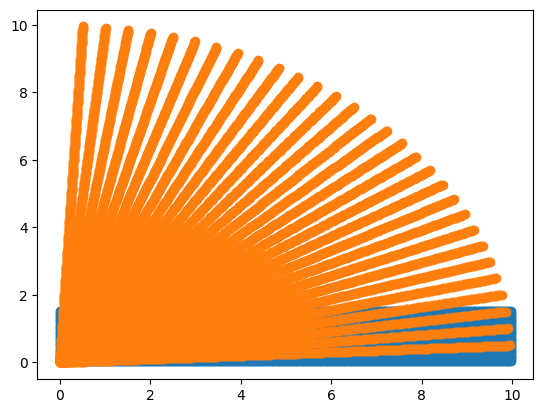

In [5]:
plt.plot(r_vect, theta_vect, 'o')
plt.plot(A1_in_sigma, A2_in_sigma, 'o')

In [6]:
num_turns = 10
tracker = collider['lhcb1'].track(particles, turn_by_turn_monitor=True, num_turns=num_turns, freeze_longitudinal=True)

In [7]:
tbt_x = collider['lhcb1'].record_last_track.x.flatten() # particle_id, turns
tbt_y = collider['lhcb1'].record_last_track.y.flatten() # particle_id, turns
particles_id = collider['lhcb1'].record_last_track.particle_id.flatten()
turns = collider['lhcb1'].record_last_track.at_turn.flatten()
df = pd.DataFrame({'particle_id': particles_id, 'x': tbt_x, 'y': tbt_y, 'turn': turns} )

keys = []
qx_tot1 = []
qx_tot2 = []
qy_tot1 = []
qy_tot2 = []
diffusions = []
for key, group in df.groupby('particle_id'):
    qx1 = abs(NAFFlib.get_tune(group.x.values[:2000], 2))
    qy1 = abs(NAFFlib.get_tune(group.y.values[:2000], 2))
    qx2 = abs(NAFFlib.get_tune(group.x.values[-2000:], 2))
    qy2 = abs(NAFFlib.get_tune(group.y.values[-2000:], 2))
    qx_tot1.append(qx1)
    qy_tot1.append(qy1)
    qx_tot2.append(qx2)
    qy_tot2.append(qy2)
    keys.append(key)
    diffusion = np.sqrt( abs(qx1-qx2)**2 + abs(qy1-qy2)**2 )
    if diffusion==0.0:
        diffusion=1e-60
    diffusion = np.log10(diffusion)
    diffusions.append(diffusion)
dff = pd.DataFrame({'particle_id': keys,'qx1': qx_tot1, 'qy1': qy_tot1, 'qx2':qx_tot2, 'qy2':qy_tot2, 'diffusion': diffusions} )
dff = dff.merge(particle_df, on='particle_id')
dff.to_parquet(f'fma.parquet')

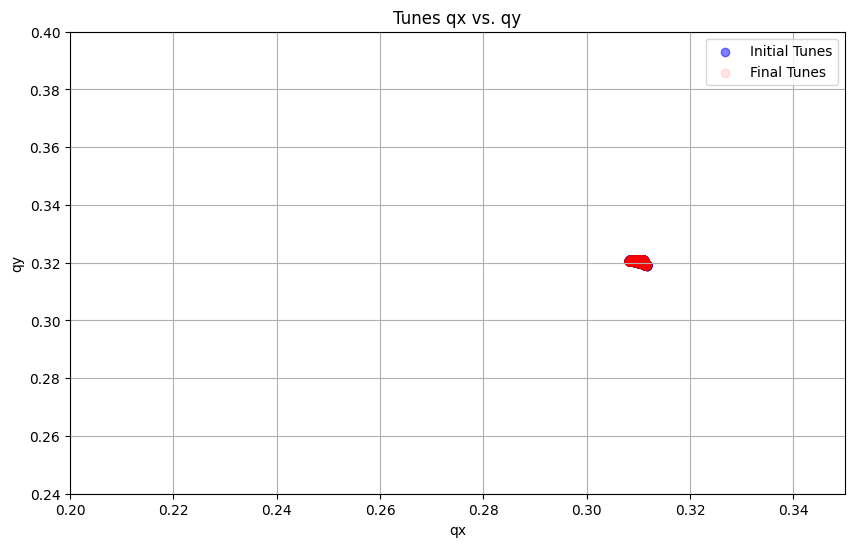

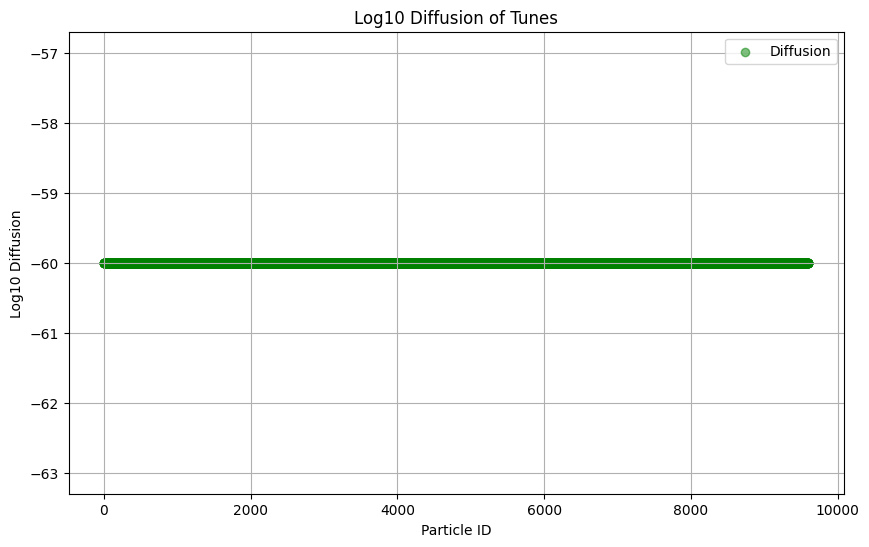

In [8]:
# Scatter plot of initial tunes qx1 vs. qy1
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(dff['qx1'], dff['qy1'], c='blue', label='Initial Tunes', alpha=0.5)
plt.xlabel('qx1')
plt.ylabel('qy1')
plt.title('Initial Tunes qx1 vs. qy1')
plt.legend()
plt.grid(True)

# Scatter plot of final tunes qx2 vs. qy2

plt.scatter(dff['qx2'], dff['qy2'], c='red', label='Final Tunes', alpha=0.1)
plt.xlabel('qx')
plt.ylabel('qy')
plt.title('Tunes qx vs. qy')
plt.legend()
plt.grid(True)
plt.xlim(0.2, 0.35)
plt.ylim(0.24, 0.4)
plt.show()

# Diffusion plot
plt.figure(figsize=(10, 6))
plt.scatter(dff['particle_id'], dff['diffusion'], c='green', label='Diffusion', alpha=0.5)
plt.xlabel('Particle ID')
plt.ylabel('Log10 Diffusion')
plt.title('Log10 Diffusion of Tunes')
plt.legend()
plt.grid(True)

plt.show()


In [9]:
tw= collider['lhcb1'].twiss()

In [10]:
tw.keys()

dict_keys(['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'W_matrix', 'kin_px', 'kin_py', 'kin_ps', 'kin_xprime', 'kin_yprime', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'dx_zeta', 'dpx_zeta', 'dy_zeta', 'dpy_zeta', 'betx1', 'bety1', 'betx2', 'bety2', 'mux', 'muy', 'muzeta', 'nux', 'nuy', 'nuzeta', 'dzeta', 'only_markers', 'particle_on_co', 'circumference', 'orientation', 'R_matrix', 'steps_r_matrix', 'R_matrix_ebe', 'slip_factor', 'momentum_compaction_factor', 'bets0', 'T_rev0', 'gamma0', 'beta0', 'p0c', 'qx', 'qy', 'qs', 'c_minus', 'c_r1_avg', 'c_r2_avg', 'eigenvalues', 'rotation_matrix', 'dmux', 'dmuy', 'bx_chrom', 'by_chrom', 'ax_chrom', 'ay_chrom', 'wx_chrom', 'wy_chrom', 'ddx', 'ddpx', 'ddy', 'ddpy', 'dqx', 'dqy', 'ddqx', 'ddqy', 'values_at', 'method', 'radiation_method', 'reference_frame', 'line_config', '_action'])

In [9]:

params = {'xtick.labelsize': 28,
'ytick.labelsize': 28,
'font.size': 30,
'figure.autolayout': True,
'figure.figsize': (15, 10),
'axes.titlesize' : 35,
'axes.labelsize' : 35,
'lines.linewidth' : 2,
'lines.markersize' : 0.1,
'legend.fontsize': 28,
'mathtext.fontset': 'stix',
'font.family': 'STIXGeneral'}
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update(params)

plt.rcParams['figure.dpi'] = 100

ft_mine = 20
lw_mine = 2
##############################################3.3752
######### Taken from https://github.com/SixTrack/SixDeskDB/blob/master/sixdeskdb/footprint.py #####################
##############################################
######## Modified 07/03/2018
"""module to plot resonance lines"""

mycolors = list('rgbcm')

def colorrotate():
    c = mycolors.pop(0)
    mycolors.append(c)
    return c

def getmn(order, kind='b'):
    """return resonance of order order of kind kind
    Parameters:
    order: order of resonance
    as list of tuples (m,n) of * resonances of order o
    kind: 't': all resonances
          'a': skew multipoles n=odd
          'b': normal multipoles n=even
          's': sum resonances (m>0,n>0), loss of beam
          'd': difference resonances (m<0,n>0) or (m>0,n<0), exchange between planes
    Returns:
    list of tuples (m,n) with |m|+|n|=order and mQx+nQy
    """
    out = []
    if 't' in kind:
        kind = 'ab'
    for m in range(0, order + 1):
        n = order - m
        if 'b' in kind and n % 2 == 0:
            out.append((m, n))
            if n > 0:
                out.append((m, -n))
        if 'a' in kind and n % 2 == 1 and m >= 0:
            out.append((m, n))
            if n > 0:
                out.append((m, -n))
        if 's' in kind and (n > 0 and m > 0):
            out.append((m, n))
        if 'd' in kind and (n > 0 and m > 0):
            out.append((m, -n))

    return list(set(out))

def find_res_xcross(m, n, q, xs, y1, y2, out):
    if n != 0:
        m, n, q, xs, y1, y2 = map(float, (m, n, q, xs, y1, y2))
        ys = (q - m * xs) / n
        if y1 <= ys <= y2:
            out.append((xs, ys))

def find_res_ycross(m, n, q, ys, x1, x2, out):
    if m != 0:
        m, n, q, ys, x1, x2 = map(float, (m, n, q, ys, x1, x2))
        xs = (q - n * ys) / m
        if x1 <= xs <= x2:
            out.append((xs, ys))

def get_res_box(m, n, l=0, qz=0, a=0, b=1, c=0, d=1):
    """get (x,y) coordinates of resonance lines with
    m, n, q:   resonance integers with mQx + nQy = q
    l, qz:    order l of resonance sideband with frequency qz
    a, b, c, d: box parameters=tune range, 
                explicitly a < qx < b and c < qy < d 
    """
    order = int(np.ceil(abs(m) * max(abs(a), abs(b)) + abs(n) * max(abs(c), abs(d))))
    out = []
    mnlq = []
    for q in range(-order, +order + 1):
        q = q - l * qz
        points = []
        find_res_xcross(m, n, q, a, c, d, points)  # find endpoint of line (a,ys) with c < ys < d
        find_res_xcross(m, n, q, b, c, d, points)  # find endpoint of line (b,ys) with c < ys < d
        find_res_ycross(m, n, q, c, a, b, points)  # find endpoint of line (xs,c) with a < xs < b
        find_res_ycross(m, n, q, d, a, b, points)  # find endpoint of line (xs,d) with a < xs < b
        points = list(set(points))
        if len(points) > 1:
            out.append(points)
            mnlq.append((m, n, l, q + l * qz))

    return out, mnlq

def plot_res_box(m, n, l=0, qz=0, a=0, b=1, c=0, d=1, color='b', linestyle='-'):
    """plot resonance (m, n, l) with sidesband of
    order l and frequency qz with qx in [a, b]
    and qy in [c, d]"""
    points, mnlq = get_res_box(m, n, l, qz, a, b, c, d)
    for p in points:
        x, y = zip(*p)
        plt.plot(x, y, color=color, linestyle=linestyle, linewidth=lw_mine)

def annotate_res_order_box(o, l=0, qz=0, a=0, b=1, c=0, d=1):
    """annotate the resonance lines of order o
    where annotations are (m, n, l). If the same
    resonance line occurs multiple times, only
    the first one is plotted"""
    l_points = []
    l_mnlq = []
    for m, n in getmn(o, 't'):
        points, mnlq = get_res_box(m, n, l, qz, a, b, c, d)
        for pp, oo in zip(points, mnlq):
            if pp not in l_points:
                x, y = zip(*pp)
                (x1, x2) = x
                (y1, y2) = y
                (xp, yp) = (x1 + (x2 - x1) / 2., y1 + (y2 - y1) / 2.)
                theta = 90 if x2 - x1 == 0 else np.arctan((y2 - y1) / (x2 - x1)) * 360 / (2 * np.pi)
                plt.gca().annotate(s='%s,%s,%s' % (str(oo[0]), str(oo[1]), int(str(oo[2]))),
                                  xy=(xp, yp), xytext=(xp, yp), xycoords='data', rotation=theta,
                                  fontsize=ft_mine, color='k', horizontalalignment='center',
                                  verticalalignment='center', annotation_clip=True)
                l_points.append(pp)
                l_mnlq.append(oo)

def annotate_specific(m, n, l=0, qz=0, a=0, b=1, c=0, d=1, xy_all=[], theta_all=[], l_points=[], l_mnlq=[]):
    """annotate the resonance lines of order o
    where annotations are (m, n, l). If the same
    resonance line occurs multiple times, only
    the first one is plotted"""
    points, mnlq = get_res_box(m, n, l, qz, a, b, c, d)
    for pp, oo in zip(points, mnlq):
        if pp not in l_points:
            x, y = zip(*pp)
            (x1, x2) = x
            (y1, y2) = y
            (xp, yp) = (x1 + (x2 - x1) / 2., y1 + (y2 - y1) / 2.)
            if x2 - x1 == 0:
                theta = 90
                yp = max(y)
                ha = 'left' if xp <= a else 'right'
                va = 'top'
                label = "          (%s,%s,%s,%s)       " % (oo[0], oo[1], int(oo[2]), int(oo[3]))
            elif y2 - y1 == 0:
                theta = 0
                xp = min(x)
                ha = 'top'
                va = 'bottom' if yp <= c else 'top'
                label = "        (%s,%s,%s,%s)         " % (oo[0], oo[1], int(oo[2]), int(oo[3]))
            else:
                theta = np.arctan((y2 - y1) / (x2 - x1)) * 360 / (2 * np.pi)
                if theta > 0:
                    xp = min(x)
                    yp = y[np.argmin(x)]
                    ha = 'left'
                    va = 'left'
                    label = "                   (%s,%s,%s,%s)                        " % (oo[0], oo[1], int(oo[2]), int(oo[3]))
                else:
                    xp = max(x)
                    yp = y[np.argmax(x)]
                    ha = 'right'
                    va = 'right'
                    label = "(%s,%s,%s,%s)                  " % (oo[0], oo[1], int(oo[2]), int(oo[3]))

            annot = plt.gca().annotate(s=label, xy=(xp, yp), xytext=(xp, yp), xycoords='data', rotation=theta + 15,
                                      fontsize=ft_mine, color='k', horizontalalignment=ha, verticalalignment=va,
                                      annotation_clip=True)
            l_points.append(pp)
            l_mnlq.append(oo)
            xy_all.append(annot)
            theta_all.append(theta)

def plot_res_order_box(o, l=0, qz=0, a=0, b=1, c=0, d=1, c1='b', lst1='-', c2='b', lst2='--', c3='g', list=[], xy_total=[], theta_total=[], annotate=False, l_points=[], l_mnlq=[]):
    """plot resonance lines up to order o and 
    sidebands of order l for frequency qz
    which lie in the square described by
    x = [a, b] and y = [c, d]"""
    if not list:
        flag_specific = False
    else:
        flag_specific = True

    for m, n in getmn(o, 'b'):
        if ((abs(m), abs(n)) in list) or (flag_specific == False):
            plot_res_box(m, n, l=0, qz=0, a=a, b=b, c=c, d=d, color=c1, linestyle=lst1)
            if l != 0:  # sidebands
                for ll in +abs(l), -abs(l):
                    plot_res_box(m, n, l=ll, qz=qz, a=a, b=b, c=c, d=d, color=c3, linestyle=lst1)
            if annotate:
                annotate_specific(m, n, l, qz, a, b, c, d, xy_all=xy_total, theta_all=theta_total, l_points=l_points, l_mnlq=l_mnlq)

    for m, n in getmn(o, 'a'):
        if ((abs(m), abs(n)) in list) or (flag_specific == False):
            plot_res_box(m, n, l=0, qz=0, a=a, b=b, c=c, d=d, color=c2, linestyle=lst2)
            if l != 0:  # sidebands
                for ll in +abs(l), -abs(l):
                    plot_res_box(m, n, l=ll, qz=qz, a=a, b=b, c=c, d=d, color=c3, linestyle=lst2)
            if annotate:
                annotate_specific(m, n, l, qz, a, b, c, d, xy_all=xy_total, theta_all=theta_total, l_points=l_points, l_mnlq=l_mnlq)

def plot_res_order(o, l=0, qz=0, c1='b', lst1='-', c2='b', lst2='--', c3='g', annotate=False):
    """plot resonance lines of order o and sidebands
    of order l and frequency qz in current plot
    range"""
    a, b = plt.xlim()
    c, d = plt.ylim()
    plot_res_order_box(o, l, qz, a, b, c, d, c1, lst1, c2, lst2, c3)
    if annotate:
        annotate_res_order_box(o, l, qz, a, b, c, d)
    plt.xlim(a, b)
    plt.ylim(c, d)

def plot_res_upto_order(o, l=0, qz=0, c1='b', lst1='-', c2='b', lst2='--', c3='g', annotate=False):
    """plot resonance lines up to order o and sidebands
    of order l and frequency qz in current plot
    range"""
    for i in range(-o, +o + 1):
        plot_res_order(i, l, qz, c1, lst1, c2, lst2, c3, annotate)

def plot_res(m, n, l=0, qz=0, color='b', linestyle='-'):
    """plot resonance of order (m, n, l) where l is
    the order of the sideband with frequency qz in
    the current plot range"""
    a, b = plt.xlim()
    c, d = plt.ylim()
    points, order = get_res_box(m, n, l, qz, a, b, c, d)
    for c in points:
        x, y = zip(*c)
        plt.plot(x, y, color=color, linestyle=linestyle, linewidth = 0.2)
    plt.xlim(a, b)
    plt.ylim(c, d)

def plot_res_order_specific(order, l=0, qz=0, c1='b', lst1='-', c2='b', lst2='--', c3='g', annotate=False, list=[]):
    """plot resonance lines of order o and sidebands
    of order l and frequency qz in current plot
    range, but the ones that are only specified in list,
    where list is a list of tuples"""
    a, b = plt.xlim()
    c, d = plt.ylim()
    xy_total = []
    theta_total = []
    l_points = []
    l_mnlq = []
    for o in order:
        plot_res_order_box(o, l, qz, a, b, c, d, c1, lst1, c2, lst2, c3, list=list, xy_total=xy_total, theta_total=theta_total, l_points=l_points, l_mnlq=l_mnlq, annotate=annotate)
    plt.xlim(a, b)
    plt.ylim(c, d)


(0.25, 0.325)

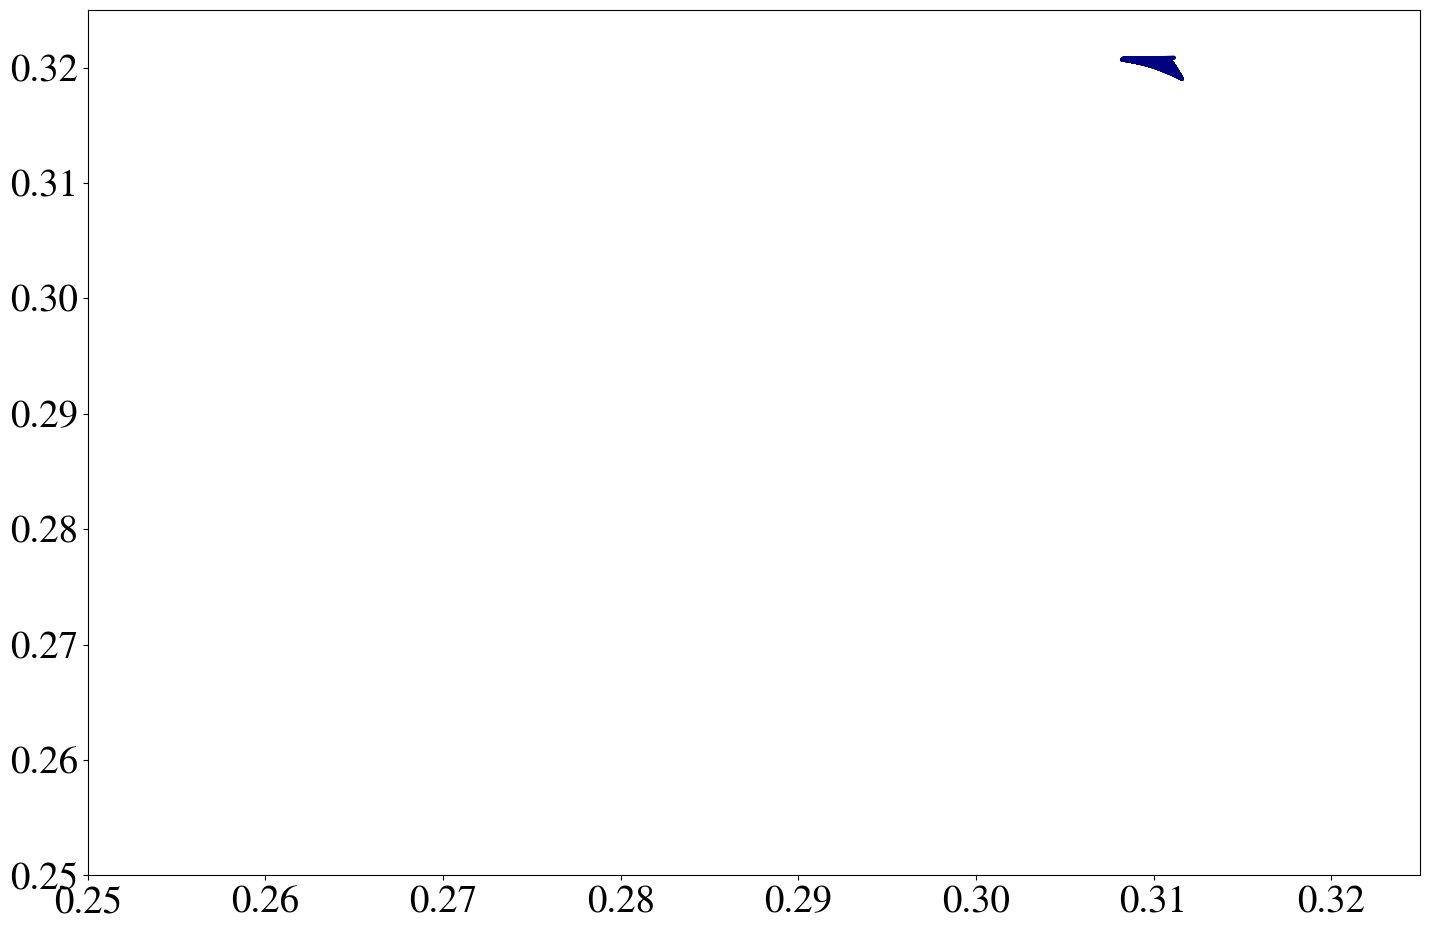

In [12]:
plt.scatter(dff['qx1'],dff['qy1'], s=3, edgecolors=None, c=dff['diffusion'], vmin=-7, vmax=-3,cmap='jet')
plt.xlim(0.25, 0.325 )
plt.ylim(0.25, 0.325)
#plt.plot(dff['diffusion'])

In [12]:
import glob
files = glob.glob('/eos/user/a/aradosla/SWAN_projects/Noise_sim_try_gpu_fma_without_noise/**/fma.parquet')
dffs = pd.DataFrame()
for file in files:
    dff = pd.read_parquet(file)
    dff = dff[(dff['at_turn'] < 2000) | (dff['at_turn'] > 8000)]
    print(file)
    dffs = pd.concat([dffs,dff], ignore_index=True)

fig, ax = plt.subplots()
plt.scatter(dffs['qx1'],dffs['qy1'], s=3, edgecolors=None, c=dffs['diffusion'], vmin=-7, vmax=-3,cmap='jet')
plt.xlim(0.20, 0.34)
plt.ylim(0.24, 0.4)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
plt.xlabel(r"Horizontal tune, $Q_x$")
plt.ylabel(r"Vertical tune, $Q_y$")
cbar=plt.colorbar(pad=0.01)
cbar.set_label(r'$\rm \log_{10}\left({\sqrt{\Delta Q_x^2 + \Delta Q_y^2}}\right)$',labelpad=45,rotation=270, fontsize=24)
#footprint.lw_mine=0.5

plot_res_upto_order(12,c1 = 'darkgrey', c2 = 'darkgrey',c3='r',annotate=False)

/eos/user/a/aradosla/SWAN_projects/Noise_sim_try_gpu_fma_without_noise/xtrack_0000/fma.parquet


KeyboardInterrupt: 